# Plan



Generate some low dimensional dynamics
Then add space on top of that




In [1459]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
import sys
import scipy as sp
import numba
from functools import partial
from mpl_toolkits import mplot3d
from sympy import Matrix
seaborn.set(font_scale=1.5,style='ticks')

In [1460]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [1566]:
dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [1567]:
Ahat = np.random.normal(size=(dim,dim))


In [1568]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [1569]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [1570]:
def construct_M(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [1571]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [1572]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = construct_M(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    #print(mse)
    return mse


In [1573]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

In [1574]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

## Generate Data

# Get this to work with cell activity with structured noise

In [1592]:
n_neurons = 120
dim = 3
nT = 9

frac_noise_dynamics = .5

x0 = np.random.normal(size=(dim,1))
x0_2 = np.random.normal(size=(dim,1))


a_params = np.random.normal(size=int(dim*(dim-1)/2))

basis_tensor = get_basis_tensor(dim)
skewM = np.einsum('i...,i...',a_params,basis_tensor)
A = caley_transform(skewM,dim)

#A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)
x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])
x_2 = np.array([np.linalg.matrix_power(A,i)@x0_2 for i in range(nT)])

x = frac_noise_dynamics*x + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)
x_2 = frac_noise_dynamics*x_2 + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [1593]:
skewM==-skewM.T

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [1594]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [1595]:
from scipy.stats import norm


act_matrix = []
act_matrix2 = []
for nix in range(n_neurons):
    
    frac_space = 0#np.random.uniform(0,1)
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    lamda2 = np.squeeze(x)@np.random.normal(size=dim)
    lamda2_2 = np.squeeze(x_2)@np.random.normal(size=(dim))

    
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = frac_space*lamda1 + (1-frac_space)*lamda2# + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
    
    activity2 = lamda1[np.random.permutation(np.arange(9))] + lamda2_2
    act_matrix2.append(activity2.copy())
act_matrix = np.array(act_matrix).T
act_matrix2 = np.array(act_matrix2).T

In [1596]:
np.linalg.norm(A,axis=0)

array([1., 1., 1.])

In [1597]:
evals, evecs = np.linalg.eig(A)

In [1598]:
#Adash = Matrix(A)
#P,J = Adash.jordan_form()

In [1599]:
x.shape

(9, 3, 1)

In [1600]:
evals

array([-0.43953562+0.89822516j, -0.43953562-0.89822516j,
        1.        +0.j        ])

In [1601]:
u1 = (evecs[:,0] + evecs[:,1]).real
u2 = (1j*(evecs[:,0] - evecs[:,1])).real

In [1602]:
offset

1

0


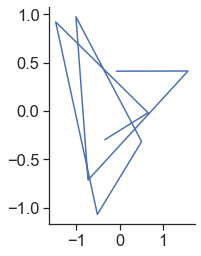

In [1603]:
plt.figure(figsize=(12,4))
offset = 0
if np.isreal(evals[0]): offset = 1
for i in range(int(np.floor(dim/2))):
    print(i)
    plt.subplot(1,4,i+1)
    ix0 = (2*i)     + offset
    ix1 = (2*i + 1) + offset
    u1 = (evecs[:,ix0] + evecs[:,ix1]).real
    u1 = u1/np.linalg.norm(u1)
    u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
    u2 = u2/np.linalg.norm(u2)
    w = np.vstack([u1,u2]).T
    projection = (np.squeeze(x)@w).T
    plt.plot(*(projection))

seaborn.despine()

In [1604]:
def calcualte_variance_explained_by_projection(wx,x,cov=None):
    """"""
    if cov is None:
        cov = np.cov(x)
    wx = np.reshape(wx,[-1,1])
    top = np.linalg.norm(cov@wx)**2
    bottom = (wx.T@cov@wx) * np.trace(cov)
    explained_variance_ratio = top/bottom
    
    return explained_variance_ratio

In [1611]:
(calcualte_variance_explained_by_projection(u1,np.squeeze(x).T) + 
 calcualte_variance_explained_by_projection(u2,np.squeeze(x).T)
)

array([[0.9278981]])

In [1612]:
calcualte_variance_explained_by_projection(u2,np.squeeze(x).T)

array([[0.38344774]])

In [1613]:
u1@u2

-3.122502256758253e-17

In [1614]:
from sklearn.decomposition import PCA

In [1615]:
pca = PCA(n_components=3)

In [1617]:
pca.fit_transform(np.squeeze(x))

array([[-3.19524715e-02,  5.93848620e-01, -2.75283616e-01],
       [-8.13176051e-01, -1.53713651e-01, -1.27360683e-01],
       [ 1.50955469e+00, -2.58160529e-01, -4.33913408e-01],
       [-1.06975154e-01,  1.27797270e+00,  1.15459375e-01],
       [-7.66055689e-01,  1.44419515e-01,  1.49850962e-02],
       [ 1.30327825e+00, -9.96749597e-01,  4.37598831e-01],
       [ 3.38910196e-01,  7.31499183e-01,  5.04870112e-01],
       [-1.43239943e+00, -1.10435839e+00,  1.22423612e-01],
       [-1.18434041e-03, -2.34757851e-01, -3.58779319e-01]])

In [1619]:
pca.explained_variance_ratio_[0]

0.5614245322249591

In [1623]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.56142453]])

In [1530]:
w.shape

(3, 2)

In [1620]:
np.sum(pca.explained_variance_ratio_[0]*np.var(x,axis=0))

0.8227200515050905

In [1621]:
pca.explained_variance_ratio_[0]

0.5614245322249591

In [1622]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.56142453]])

In [1549]:
pca.explained_variance_[0]

0.655568508887803

In [1550]:
cov.shape

(3, 3)

In [1344]:
np.linalg.norm(cov@pca.components_[:,0].reshape([-1,1]))

0.19210315538667472

In [1331]:
w.shape

(3, 2)

In [ ]:
x.sh

In [1321]:
w[:,0].T@cov@w[:,0]/np.sum(np.trace(cov)) + w[:,1].T@cov@w[:,1]

0.6761277597457196

In [1282]:
np.squeeze(x)@w[:,0]@np.linalg.pinv(w[:,0].reshape(1,-1))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 9)

In [1283]:
np.((np.squeeze(x)@w[:,0]).reshape(-1,1)@np.linalg.pinv(w[:,0].reshape(-1,1)))

SyntaxError: invalid syntax (<ipython-input-1283-ff2ef4cdd074>, line 1)

In [1284]:
w.shape

(3, 2)

In [1285]:
x.shape

(9, 3, 1)

In [1286]:
np.linalg.pinv(w[:,0].reshape(-1,1))

array([[ 0.98982211, -0.04503086,  0.13499779]])

In [1287]:
w[:,0].T@cov@w[:,0]/np.sum(np.trace(cov)) + w[:,1].T@cov@w[:,1]/np.sum(np.trace(cov))

0.7714930449196715

In [1288]:
cov = np.cov(np.squeeze(x).T)

np.linalg.norm(cov@w)/np.sum(np.trace(cov) + w.T@cov@w)

0.14297374532642163

In [1289]:
cov.shape

(3, 3)

In [1290]:
w.shape

(3, 2)

In [1291]:
np.sum(np.cov(projection).diagonal())/np.sum(np.cov(np.squeeze(x)-np.mean(np.squeeze(x),axis=0)).diagonal())

0.4533470590202305

In [1292]:
np.sum(np.cov(projection).diagonal())

0.3899911349567755

In [1293]:
np.var(projection - np.mean(projection,axis=0))/np.var(x-np.mean(x,axis=0))

0.7812092488190309

In [1294]:
np.var(projection)

0.17337227464075167

In [1295]:
x.shape

(9, 3, 1)

In [1296]:
np.var(x,axis=1)

array([[0.09084539],
       [0.1347003 ],
       [0.19014944],
       [0.06002198],
       [0.15112739],
       [0.19353211],
       [0.04272679],
       [0.16952417],
       [0.19429051]])

In [1298]:
evals, evecs = np.linalg.eig(A)

In [1299]:
real_evec = int(np.where(np.isreal(evals))[0])
nullspace = sp.linalg.null_space(evecs[:,real_evec].reshape(1,-1))
lns = np.linspace(-2,2,num=2)
xx, yy = np.meshgrid(lns,lns)
z = np.einsum('ij,klj->kli',nullspace,np.dstack([xx,yy])) + np.squeeze(np.mean(x,axis=0))[None,None]

# plot the plane
#ax.plot_surface(xx, yy, z, alpha=0.5)


In [1300]:
np.mean(x,axis=0)

array([[-0.09415678],
       [-0.16113386],
       [ 0.44098909]])

In [1301]:
evals

array([-0.42970301+0.90297028j, -0.42970301-0.90297028j,
        1.        +0.j        ])

In [1302]:
(-1*nullspace[:,0] + -1*nullspace[:,1])

array([-0.62575473+0.j, -1.17157405+0.j, -0.48563904+0.j])

In [1303]:
xx[0,0]

-2.0

In [1304]:
np.sum(-1*nullspace[:,0] + -1*nullspace[:,1])

(-2.2829678107143208+0j)

In [1305]:
np.allclose(0,evecs[:,0].reshape(1,-1)@nullspace)

False

In [1306]:
evals

array([-0.42970301+0.90297028j, -0.42970301-0.90297028j,
        1.        +0.j        ])

In [1307]:
nullspace

array([[-0.31320703-0.j,  0.93896175-0.j],
       [ 0.91412259-0.j,  0.25745146-0.j],
       [ 0.25745146-0.j,  0.22818758-0.j]])

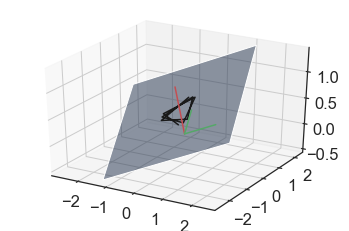

In [1309]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(x[:,0,0],x[:,1,0],x[:,2,0],color='k')

ax.plot3D(*np.vstack([np.zeros(3),evecs[:,real_evec]]).T,color='r')
#ax.plot3D(*np.vstack([np.zeros(3),evecs[:,1]]).T)
#ax.plot3D(*np.vstack([np.zeros(3),evecs[:,2]]).T)
ax.plot3D(*np.vstack([np.zeros(3),nullspace[:,0].real]).T,color='g')
ax.plot3D(*np.vstack([np.zeros(3),nullspace[:,1].real]).T,color='g')

#ax.set_xlim(-1,1)
#ax.set_ylim(-1,1)
#ax.set_zlim(-1,1)
ax.plot_surface(z[:,:,0],z[:,:,1],z[:,:,2], alpha=0.5)

plt.show()

# check if simulated activity comes out as periodic

In [874]:
@numba.jit(nopython=True)
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [875]:
resps_state_g1 = act_matrix.copy().T
resps_state_g2 = act_matrix2.copy().T

In [876]:
res_t1 = []
res_t2 = []
all_cc = []
all_shuffle_cc = []
t_ = np.linspace(0,2*np.pi,9)
NSHUFF = 100
params_ranges = [slice(0,4,.5),slice(0,2*np.pi,np.pi/9)]
#params_ranges = [slice(0,4,.5),slice(0,np.pi,np.pi/9),slice(0,1,.25),slice(0,1,.25)]


n_neurons = resps_state_g1.shape[0]



for i in range(n_neurons):
    sys.stdout.write('\r running cell:{}'.format(i))
    sys.stdout.flush()
    
    y1 = resps_state_g1[i] #np.random.permutation(resps_state_g1[i])
    y2 = resps_state_g2[i] #np.random.permutation(resps_state_g2[i])
    spks = y1# - (y1 + y2)/2.
    y = spks
    #y -= np.mean(y)
    #y /=np.max(y)

    #res1 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res1 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]
    
    cc1_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res1_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])
        


    spks = y2# - (y1 + y2)/2.
    y = spks
    #y = np.random.permutation(spks)
    #y -= np.mean(y)
    #y /=np.max(y)


    #res2 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res2 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc2 = np.corrcoef(y,np.cos(res2[0]*t_ + res2[1]))[0,1]
    
    cc2_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res2_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc2_shuff.append(np.corrcoef(spks_shuff,np.cos(res2_shuff[0]*t_ + res2_shuff[1]))[0,1])

    all_cc.append([cc1,cc2])
    all_shuffle_cc.append([cc1_shuff,cc2_shuff])
    
    res_t1.append(res1)
    res_t2.append(res2)
all_cc = np.array(all_cc)
res_t1 = np.array(res_t1)
res_t2 = np.array(res_t2)

 running cell:119

In [877]:
import scipy.stats as stt

In [878]:
p_vals = []
for cell_ix,cell in enumerate(all_cc):
    tmp = []
    for task_nr in range(2):
        p1 = stt.percentileofscore(all_shuffle_cc[cell_ix][task_nr],cell[task_nr])
        tmp.append(p1)
    p_vals.append(tmp)

In [879]:
print(np.mean(np.array(p_vals)[:,0]>97.5))
print(np.mean(np.array(p_vals)[:,1]>97.5))

0.16666666666666666
0.075


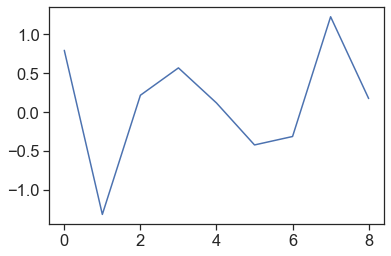

In [881]:
plt.plot(act_matrix[:,0])

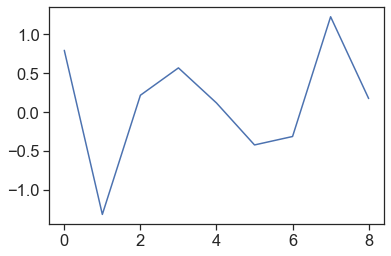

In [882]:
plt.plot(act_matrix[:,0])

[[ 1.         -0.03167788]
 [-0.03167788  1.        ]]


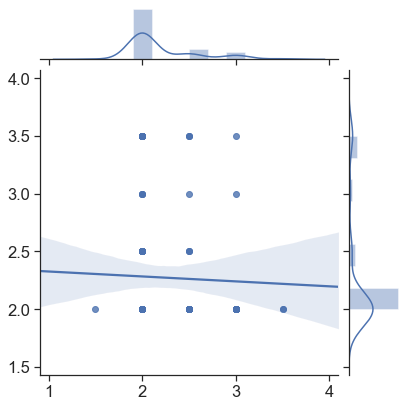

In [883]:
seaborn.jointplot(res_t1[:,0],res_t2[:,0],kind='reg')
print(np.corrcoef(res_t1[:,0],res_t2[:,0]))